Add google disk

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Import libraries

In [ ]:
import numpy as np
import keras
from keras import applications, Sequential, Model, optimizers, models
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, History
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tqdm import tqdm
import os
import h5py
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Variables containing train and test directories. 
Some constant variables.

In [ ]:
trainInput = "/content/gdrive/My Drive/pneumonia/chest_xray/chest_xray/train/"
testInput = "/content/gdrive/My Drive/pneumonia/chest_xray/chest_xray/test/"
validationInput = "/content/gdrive/My Drive/pneumonia/chest_xray/chest_xray/val/"
size = 199
epochs = 3
fileName = "/content/gdrive/My Drive/pneumonia/images.h5"
modelsDir = "/content/gdrive/My Drive/pneumonia/model1/"

Get the images and labels

In [ ]:
x = h5py.File(fileName, "r")["imagesTrain"][:]
print(x.shape)

(5216, 199, 199, 3)


In [ ]:
dset = h5py.File(fileName, "r")
labelsTrain, imagesTrain, labelsTest, imagesTest, labelsValidation, imagesValidation = dset["labelsTrain"][:], dset["imagesTrain"][:], dset["labelsTest"][:], dset["imagesTest"][:], dset["labelsValidation"][:], dset["imagesValidation"][:]

Reshape if fit_generator dont work

In [ ]:
labelsTrain = to_categorical(labelsTrain, 2)
labelsTest = to_categorical(labelsTest, 2)
labelsValidation = to_categorical(labelsValidation, 2)
print("Train:", imagesTrain.shape, "Test:", imagesTest.shape, "Validation:", imagesValidation.shape)
print("Train:", labelsTrain.shape, "Test:", labelsTest.shape, "Validation:", labelsValidation.shape)

Train: (5216, 199, 199, 3) Test: (624, 199, 199, 3) Validation: (16, 199, 199, 3)
Train: (5216, 2) Test: (624, 2) Validation: (16, 2)


Add an model, the weights can be none or imagenet. Imagenet is pre-trained on ImageNet.     
include_top is set False in order to exclude the last three layers (including the final softmax layer with 200 classes of output)

This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
Reduce learning rate when a metric has stopped improving.

Flatten() layer to flatten the tensor output. Dense is 2D layer which support the specification of their input shape. relu and softmax are different activations which used with layers, either can be used by activation layers. Activations: https://keras.io/activations/. Optimizers: https://keras.io/optimizers/. Losses: https://keras.io/losses/. Metrics: https://keras.io/metrics/. Compilation: https://keras.io/getting-started/sequential-model-guide/.

Measure time and creation of fit_generator: https://keras.io/models/model/#fit_generator , https://keras.io/models/model/#fit

Save the model

In [ ]:
reduceLearningRate = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, cooldown=2, min_lr=0.001, verbose=1)
# reduceLearningRate = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1) 
earlyStop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callbacks = [reduceLearningRate, earlyStop]

In [ ]:
datagen = ImageDataGenerator(
    zoom_range=0.1,
    height_shift_range=0.1,
    width_shift_range=0.1,
    rotation_range=10
)

In [ ]:
def trainModel(model, name):
  global history
  pattern = model(weights="imagenet", include_top=False, input_shape=[size, size, 3])

  addModel = Sequential()

  addModel.add(Flatten(input_shape=pattern.output_shape[1:]))
  addModel.add(Dense(512, activation="relu"))
  addModel.add(Dropout(0.15))
  addModel.add(Dense(1024, activation="relu"))
  addModel.add(Dropout(0.5))
  addModel.add(Dense(2, activation="softmax"))

  md = Model(inputs=pattern.input, outputs=addModel(pattern.output))
  md.compile(loss="categorical_crossentropy", 
                  optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9), 
                  metrics=["accuracy"])
  
  history = md.fit(datagen.flow(imagesTrain, labelsTrain, batch_size=32),
                   validation_data=datagen.flow(imagesTest, labelsTest),
                   callbacks=callbacks, epochs=epochs, verbose=1)
  
  md.save(modelsDir + name + ".h5")

In [ ]:
trainModel(applications.Xception, "Xception")

Epoch 1/3
163/163 [==============================] - 60s 369ms/step - loss: 0.1854 - accuracy: 0.9417 - val_loss: 0.9794 - val_accuracy: 0.8622
Epoch 2/3
163/163 [==============================] - 59s 362ms/step - loss: 0.0687 - accuracy: 0.9764 - val_loss: 2.1945 - val_accuracy: 0.6795
Epoch 3/3
163/163 [==============================] - 59s 364ms/step - loss: 0.0662 - accuracy: 0.9783 - val_loss: 0.4146 - val_accuracy: 0.8734


# Xception results

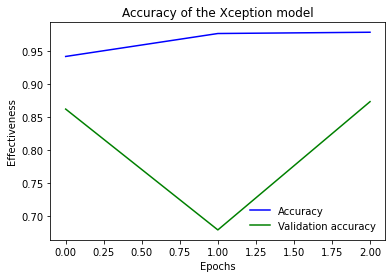

In [ ]:
plt.plot(history.history["accuracy"], color="b", label="Accuracy")
plt.plot(history.history["val_accuracy"], color="g", label="Validation accuracy")
plt.legend(loc="lower right", frameon=False)
plt.title("Accuracy of the Xception model")
plt.xlabel("Epochs")
plt.ylabel("Effectiveness")
plt.show()

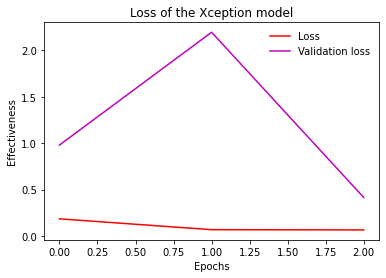

In [ ]:
plt.plot(history.history["loss"], color="r", label="Loss")
plt.plot(history.history["val_loss"], color="m", label="Validation loss")
plt.legend(loc="upper right", frameon=False)
plt.title("Loss of the Xception model")
plt.xlabel("Epochs")
plt.ylabel("Effectiveness")
plt.show()

Load model and prediction

In [ ]:
def prepareTestImages(dir_test_image):

    labels = []
    images = []

    for nextDirectory in os.listdir(dir_test_image):
        if not nextDirectory.startswith("."):
            if nextDirectory in "NORMAL":
                label = 0
            elif nextDirectory in "PNEUMONIA":
                label = 1
            else:
                label = 2

            currentDirectory = dir_test_image + nextDirectory
            if not currentDirectory.startswith("."):
                for files in os.listdir(currentDirectory):
                    if files.endswith('.jpg') or files.endswith('.jpeg'):
                        imagePath = currentDirectory + "/" + files
                        img = Image.open(imagePath)
                        img = img.resize((size, size)).convert("RGB")
                        data = np.array(img.getdata())
                        img = 2 * (data.reshape((img.size[0], img.size[1], 3)).astype(np.float32) / 255) - 1
                        images.append(img)
                        labels.append(label)

    labels = np.asarray(labels)

    out = h5py.File("/content/gdrive/My Drive/pneumonia/imagesTest.h5", "a")
    out.create_dataset("imagesTest", data=images)
    out.create_dataset("labelsTest", data=labels)
    out.close()

In [ ]:
prepareTestImages("/content/gdrive/My Drive/pneumonia/test/")

In [ ]:
dset = h5py.File("/content/gdrive/My Drive/pneumonia/imagesTest.h5", "r")
imagesTmp = dset["imagesTest"][:]
labelsTmp = dset["labelsTest"][:]

In [ ]:
def modelsTest(modelsDir):

  modelStat = {}

  for modelPath in os.listdir(modelsDir):
    if not modelPath.startswith("."):
      dirModel = modelsDir + "/" + modelPath
      name = modelPath.split(".")[0]
      model = models.load_model(dirModel)
      predictions = model.predict(imagesTmp[:])
      accuracy = 0

    for i in range(len(predictions)):
      if labelsTmp[i] == np.argmax(predictions[i]):
        accuracy += 1
    modelStat[name] = accuracy/len(predictions)*100

  for key, value in modelStat.items():
    print("Model is {}\nAccuracy of predictions is: {}%".format(key, value))

  _, ax = plt.subplots()
  ax.bar(modelStat.keys(), modelStat.values(), color='#539caf', align="center")
  ax.set_ylabel("Accuracy")
  ax.set_xlabel("Models")
  plt.savefig("test_stat.png")
   

Model is Xception
Accuracy of predictions is: 93.91025641025641%


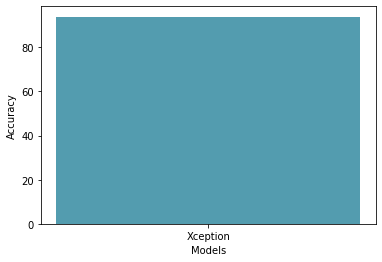

In [ ]:
modelsTest(modelsDir)